<a href="https://colab.research.google.com/github/Rishika70/Topic-Modelling-on-Neurology-with-LLM/blob/main/Topic_Modelling_on_Neurology_with_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

### **This project aims to develop a system for analyzing and querying a collection of neurological research documents using topic modeling and large language models (LLMs).  The system will categorize documents based on keywords related to diseases, treatments, types of neurological conditions, and other relevant topics.  A key feature will be a question-answering capability that leverages both the document categories and semantic similarity to provide relevant excerpts from documents in response to user queries.  Ultimately, the goal is to create a tool that efficiently facilitates research by enabling quick analysis and retrieval of information from a large corpus of neurological research papers.**

#Import Libraries and Load SciBERT Models

In [ ]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 29.2 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import re
import numpy as np
import torch
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import fitz  # PyMuPDF for PDF text extraction
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
embedding_model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

#Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path where PDFs are extracted
extracted_folder_path = '/content/drive/MyDrive/Topic Modelling on Neurology with LLM/Data/ScienceDirect_articles_07Nov2024_17-51-14.882.zip (Unzipped Files)'

# List all PDFs in the folder
pdf_files = [os.path.join(extracted_folder_path, f) for f in os.listdir(extracted_folder_path) if f.endswith('.pdf')]
print(f"Found {len(pdf_files)} PDFs.")

Found 18 PDFs.


In [ ]:
# Initialize SciBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
embedding_model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

#Text Pre-Processing

##Remove Punctuations,Tags, URLS and whitespaces

In [ ]:
import re

def clean_text(text):
  # Remove punctuation
  text = re.sub(r'[^\w\s]', '', text)
  # Remove tags
  text = re.sub(r'<.*?>', '', text)
  # Remove URLs
  text = re.sub(r'http\S+', '', text)
  # Remove extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()
  return text

##Tokenization

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def tokenize_text(text):
  """Tokenizes the input text using NLTK's word tokenizer.

  Args:
    text: The text to be tokenized.

  Returns:
    A list of tokens.
  """
  tokens = word_tokenize(text)
  return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##Remove stop words

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
  """Removes stop words from a list of tokens.

  Args:
    tokens: A list of tokens.

  Returns:
    A list of tokens without stop words.
  """
  filtered_tokens = [w for w in tokens if not w.lower() in stop_words]
  return filtered_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Convert to lowercase

In [ ]:
def lowercase(text):
  """Converts text to lowercase.

  Args:
    text: The text to be converted.

  Returns:
    The lowercase version of the text.
  """
  return text.lower()

##Stemming and Lemmatization

In [ ]:
from nltk.stem import PorterStemmer

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

def stem_tokens(tokens):
    """Stems a list of tokens using Porter Stemmer.

    Args:
        tokens: A list of tokens.

    Returns:
        A list of stemmed tokens.
    """
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    print(stemmed_tokens)  # Print the stemmed tokens for debugging
    return stemmed_tokens


In [ ]:
 ##Lemmatization
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
  """Lemmatizes a list of tokens using WordNet Lemmatizer.

  Args:
    tokens: A list of tokens.

  Returns:
    A list of lemmatized tokens.
  """
  print([lemmatizer.lemmatize(token) for token in tokens])
  return [lemmatizer.lemmatize(token) for token in tokens]


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Extract text from PDF
def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

In [ ]:
# Generate embeddings using SciBERT
def get_embeddings(texts):
    """Generate embeddings using SciBERT."""
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        outputs = embedding_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()  # Pooling the embeddings (mean over token embeddings)
    return embeddings

In [ ]:
# Perform clustering using K-means
def perform_clustering(embeddings, num_clusters=8):
    """Cluster research papers using K-means clustering."""
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(embeddings)
    return kmeans.labels_, kmeans.cluster_centers_

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

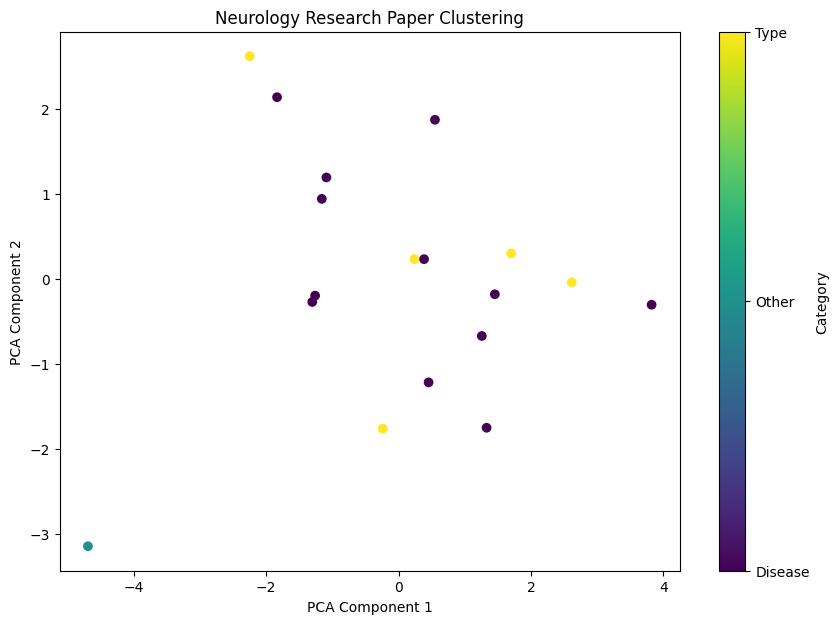

                                            Document  \
0  /content/drive/MyDrive/Topic Modelling on Neur...   
1  /content/drive/MyDrive/Topic Modelling on Neur...   
2  /content/drive/MyDrive/Topic Modelling on Neur...   
3  /content/drive/MyDrive/Topic Modelling on Neur...   
4  /content/drive/MyDrive/Topic Modelling on Neur...   

                                                Text Category  
0  ageing research review 99 2024 102390 availabl...  Disease  
1  ageing research review 99 2024 102355 availabl...  Disease  
2  ageing research review 99 2024 102325 availabl...     Type  
3  ageing research review 99 2024 102392 availabl...  Disease  
4  ageing research review 99 2024 102357 availabl...  Disease  


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Keywords for semi-supervised classification
keyword_dict = {
    'Disease': ['Alzheimer', 'Parkinson', 'dementia'],
    'Type': ['genetic', 'neurological', 'cognitive'],
    'Treatment': ['therapy', 'medication', 'intervention'],
    'Other': ['risk', 'factors', 'lifestyle']
}

# Preprocessing Function
def preprocess_text(text):
  """Preprocesses text by removing punctuation,
  lowercasing, tokenizing, removing stop words, and lemmatizing."""
  text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
  text = text.lower()  # Convert to lowercase
  tokens = word_tokenize(text)  # Tokenize the text
  stop_words = set(stopwords.words('english'))  # Get English stop words
  tokens = [token for token in tokens if token not in stop_words]  # Remove stop words
  lemmatizer = WordNetLemmatizer()  # Initialize WordNetLemmatizer
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize tokens
  return ' '.join(lemmatized_tokens)  # Join tokens back into a string

def classify_text(text):
    """Classifies text into Disease, Type, Treatment, or Other based on keywords."""
    for category, keywords in keyword_dict.items():
        if any(keyword in text for keyword in keywords):
            return category
    return 'Other'  # Default to 'Other' if no keywords match

# Visualization for Clusters
def visualize_clusters(embeddings, labels):
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(embeddings)
    plt.figure(figsize=(10, 7))

    # Convert labels to numerical values for color mapping
    unique_labels = np.unique(labels)
    label_mapping = {label: i for i, label in enumerate(unique_labels)}
    numerical_labels = [label_mapping[label] for label in labels]

    plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1],
                c=numerical_labels, cmap='viridis', marker='o') # Use numerical_labels for color
    plt.title("Neurology Research Paper Clustering")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")

    # Add a colorbar with category labels
    cbar = plt.colorbar()
    cbar.set_ticks(np.arange(len(unique_labels)))
    cbar.set_ticklabels(unique_labels)
    cbar.set_label('Category')

    plt.show()

# Full Analysis
def analyze_research_papers(pdf_files, num_clusters=4):
    documents = []
    for pdf_file in pdf_files:
        text = extract_text_from_pdf(pdf_file)
        preprocessed_text = preprocess_text(text)
        documents.append(preprocessed_text)

    # Generate embeddings using SciBERT
    embeddings = get_embeddings(documents)

    # Label documents based on keywords
    labels = [classify_text(text) for text in documents]

    # Visualization
    visualize_clusters(embeddings, labels)

    # DataFrame to store results
    df = pd.DataFrame({
        'Document': pdf_files,
        'Text': documents,
        'Category': labels
    })
    print(df.head())
    return df

# Run analysis
df = analyze_research_papers(pdf_files=pdf_files, num_clusters=4)


The code performs clustering and visualization of scientific research papers based on their textual content.  Let's break down the key steps and the likely appearance of the graph:

1. **Data Loading and Preprocessing:**
   - It loads PDF files from a specified directory.
   - It preprocesses the text from each PDF:
     - Cleaning (removing punctuation, HTML tags, URLs, extra whitespace)
     - Tokenization (splitting text into words)
     - Stop word removal (eliminating common words like "the," "a," "is")
     - Lowercasing
     - Stemming/Lemmatization (reducing words to their root form)

2. **SciBERT Embeddings:**
   - Uses SciBERT (a scientific domain-specific language model) to generate embeddings (numerical representations) of the preprocessed text.  These embeddings capture semantic meaning.

3. **Clustering (K-Means):**
   - Applies K-Means clustering to group the papers based on their SciBERT embeddings.  The code uses `num_clusters=4`, meaning it groups the papers into four clusters.

4. **Semi-supervised Classification (Keyword-based):**
   - It assigns each paper to a category (Disease, Type, Treatment, or Other) based on the presence of specific keywords.  This is a rudimentary classification step.  It's not used for the clustering itself but rather for labeling the data points in the visualization.

5. **Visualization (PCA and Scatter Plot):**
   - Reduces the dimensionality of the SciBERT embeddings using Principal Component Analysis (PCA) to 2 dimensions.  This allows for visualization in a 2D scatter plot.
   - Creates a scatter plot where each point represents a research paper.
   - The points are colored based on the assigned category (from the keyword-based classification). Each color represents a category (Disease, Type, Treatment, or Other).
   - The plot will likely show clusters of points, with each cluster representing a group of papers with similar content. The cluster separation might not be perfect, due to the limitations of keyword-based classification and the nature of K-Means clustering. The colors will indicate the category of papers within each cluster.


**In summary:** You'll see a 2D scatter plot where points are colored according to the four categories determined by keywords.  Clusters of points suggest groupings of papers with similar content, as determined by the SciBERT embeddings and K-means clustering.  The visualization helps to explore the relationships between the research papers. The quality of the clustering and visualization would depend on the quality of the text preprocessing and keyword dictionary

In [ ]:
# Save the DataFrame to a CSV file in Google Drive
csv_file_path = '/content/drive/MyDrive/Topic Modelling on Neurology with LLM/Data/cleaned_data.csv'
df.to_csv(csv_file_path, index=False)

In [ ]:
from collections import defaultdict

# Define the expanded keyword dictionary with primary and secondary keywords
keywords = {
    "Disease": ["Alzheimer’s", "Parkinson’s", "Dementia", "cognitive decline", "motor disorder"],
    "Type": ["neurodegenerative", "inflammatory", "genetic", "age-related"],
    "Treatment": ["medication", "therapy", "surgery", "pharmaceutical", "neurostimulation"],
    "Other": ["imaging", "biomarkers", "epidemiology", "genetic markers"]
}

# Function to classify text based on keywords
def classify_text(text):
    category_scores = defaultdict(int)

    for category, terms in keywords.items():
        for term in terms:
            if term.lower() in text.lower():
                # Increase score, adjust weight for primary vs secondary keywords if needed
                category_scores[category] += 1

    # Determine the category with the highest score
    if category_scores:
        return max(category_scores, key=category_scores.get)
    return "Uncategorized"

# Example usage on a research paper abstract
text_sample = "The study focuses on neurodegenerative diseases such as Alzheimer’s and the effect of cognitive therapy."
category = classify_text(text_sample)
print(f"Classified as: {category}")



Classified as: Disease


In [ ]:
from collections import defaultdict
import pandas as pd

# Expanded keywords with primary and secondary terms
keywords = {
    "Disease": {"primary": ["Alzheimer’s", "Parkinson’s", "Dementia"],
                "secondary": ["cognitive decline", "neurodegeneration"]},
    "Type": {"primary": ["neurodegenerative", "genetic"],
             "secondary": ["age-related", "inflammatory"]},
    "Treatment": {"primary": ["therapy", "medication", "surgery"],
                  "secondary": ["neurostimulation", "pharmaceutical"]},
    "Other": {"primary": ["imaging", "biomarkers"],
              "secondary": ["genetic markers", "epidemiology"]}
}

# Classification function with multi-label and scoring
def classify_text_multi_label(text, threshold=2):
    category_scores = defaultdict(int)

    # Calculate scores for each category
    for category, terms in keywords.items():
        for term in terms["primary"]:
            if term.lower() in text.lower():
                category_scores[category] += 2  # Higher weight for primary terms
        for term in terms["secondary"]:
            if term.lower() in text.lower():
                category_scores[category] += 1  # Lower weight for secondary terms

    # Determine categories that meet the score threshold
    assigned_categories = [category for category, score in category_scores.items() if score >= threshold]

    return assigned_categories if assigned_categories else ["Uncategorized"]

# Function to classify all documents and create a DataFrame
def classify_documents(documents):
    classified_data = []

    for i, text in enumerate(documents):
        categories = classify_text_multi_label(text)
        classified_data.append({"Document_ID": i, "Text": text, "Categories": categories})

    return pd.DataFrame(classified_data)

# Assuming `df` contains the text data, replace it with the actual DataFrame
documents = df['Text'].tolist()  # Extract text data from the DataFrame 'df'

# Classify documents and store results in a DataFrame
df_classified = classify_documents(documents)

# Display the DataFrame with classifications
print(df_classified)



    Document_ID                                               Text  \
0             0  ageing research review 99 2024 102390 availabl...   
1             1  ageing research review 99 2024 102355 availabl...   
2             2  ageing research review 99 2024 102325 availabl...   
3             3  ageing research review 99 2024 102392 availabl...   
4             4  ageing research review 99 2024 102357 availabl...   
5             5  ageing research review editorinchief c frances...   
6             6  ageing research review 99 2024 102383 availabl...   
7             7  ageing research review 99 2024 102385 availabl...   
8             8  ageing research review 99 2024 102407 availabl...   
9             9  ageing research review 99 2024 102380 availabl...   
10           10  ageing research review 99 2024 102360 availabl...   
11           11  ageing research review 99 2024 102402 availabl...   
12           12  ageing research review 99 2024 102354 availabl...   
13           13  age

In [ ]:
df.head()

,Document,Text,Category
0,/content/drive/MyDrive/Topic Modelling on Neur...,ageing research review 99 2024 102390 availabl...,Disease
1,/content/drive/MyDrive/Topic Modelling on Neur...,ageing research review 99 2024 102355 availabl...,Disease
2,/content/drive/MyDrive/Topic Modelling on Neur...,ageing research review 99 2024 102325 availabl...,Type
3,/content/drive/MyDrive/Topic Modelling on Neur...,ageing research review 99 2024 102392 availabl...,Disease
4,/content/drive/MyDrive/Topic Modelling on Neur...,ageing research review 99 2024 102357 availabl...,Disease


In [ ]:
df.shape

(18, 3)

In [ ]:
df.count()

,0
Document,18
Text,18
Category,18


#Understanding data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Document  18 non-null     object
 1   Text      18 non-null     object
 2   Category  18 non-null     object
dtypes: object(3)
memory usage: 560.0+ bytes


#Duplicate Values

In [ ]:
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, list)).any():  # Check if column has lists
        df[col] = df[col].map(lambda x: tuple(x) if isinstance(x, list) else x)

# Now check for duplicates
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,False


#Missing Values

In [ ]:
# Missing Values/Null Values Count
df.isna().sum()

,0
Document,0
Text,0
Category,0


In [ ]:
# Display unique categories in the 'Category' column
print(df['Category'].unique())

['Disease' 'Type' 'Other']


#**Prompting-Techniques**

##Categorical Prompting

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
# Load sentence transformer for semantic similarity
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# according to category generate prompts to help researchers

def generate_research_prompts(category, keywords):
  """Generates research prompts based on a category and keywords.

  Args:
    category: The research category (e.g., "Disease", "Treatment").
    keywords: A list of keywords relevant to the category.

  Returns:
    A list of research prompts.
  """

  prompts = []

  # Generate prompts based on different prompt templates
  if category == "Disease":
    prompts.extend([
        f"Investigate the genetic basis of {keywords[0]}.",
        f"Explore the relationship between lifestyle factors and the risk of {keywords[1]}.",
        f"Analyze the effectiveness of different therapies for {keywords[2]}."
    ])

  elif category == "Type":
    prompts.extend([
      f"Compare and contrast {keywords[0]} and {keywords[1]} diseases.",
      f"Study the prevalence of {keywords[2]} neurological disorders in different populations.",
      f"Investigate the role of genetic factors in {keywords[0]} diseases."
    ])

  elif category == "Treatment":
      prompts.extend([
          f"Evaluate the efficacy of {keywords[0]} for {keywords[1]}.",
          f"Explore novel treatment strategies for {keywords[2]}.",
          f"Assess the long-term effects of {keywords[0]} on patients with {keywords[1]}."
      ])

  elif category == "Other":
      prompts.extend([
          f"Develop new biomarkers for early detection of {keywords[0]}",
          f"Investigate the role of {keywords[1]} in disease progression",
          f"Explore the use of {keywords[2]} for improved patient outcomes"
      ])
  else:
      prompts.append(f"Explore research related to {keywords}")

  return prompts

# Example usage
disease_keywords = ["Alzheimer's Disease", "Parkinson's Disease", "Dementia"]
disease_prompts = generate_research_prompts("Disease", disease_keywords)
print("Disease Prompts:")
for prompt in disease_prompts:
  print(prompt)

treatment_keywords = ["medication", "therapy", "surgery"]
treatment_prompts = generate_research_prompts("Treatment", treatment_keywords)
for prompt in treatment_prompts:
  print(prompt)

Disease Prompts:
Investigate the genetic basis of Alzheimer's Disease.
Explore the relationship between lifestyle factors and the risk of Parkinson's Disease.
Analyze the effectiveness of different therapies for Dementia.
Evaluate the efficacy of medication for therapy.
Explore novel treatment strategies for surgery.
Assess the long-term effects of medication on patients with therapy.


##Function to Generate Research Prompts Across Various Categories in Neurology and Beyond

In [ ]:
def generate_research_prompts(category, keywords):
    """Generates research prompts based on category and keywords."""
    prompts = []
    if category == "Disease":
        for keyword in keywords:
            prompts.extend([
                f"What are the latest findings on the genetic basis of {keyword}?",
                f"How do lifestyle factors influence the risk of developing {keyword}?",
                f"Compare and contrast the effectiveness of different therapies for {keyword}.",
                f"What are the early warning signs and symptoms of {keyword}?",
                f"What are the challenges in diagnosing {keyword} accurately?",
                f"What advancements have been made in understanding the progression of {keyword}?",
                f"How can early interventions impact the prognosis of {keyword}?",
            ])
    elif category == "Type":
        for keyword in keywords:
            prompts.extend([
                f"What are the distinct characteristics of {keyword} neurological disorders?",
                f"How prevalent are {keyword} neurological disorders in different populations?",
                f"What are the genetic and environmental factors associated with {keyword} disorders?",
                f"How do {keyword} disorders affect cognitive function and daily living?",
                f"What are promising avenues for research into {keyword} disorders?",
                f"What role does imaging technology play in studying {keyword} disorders?",
                f"How does {keyword} influence neurological comorbidities?",
            ])
    elif category == "Treatment":
        for keyword in keywords:
            prompts.extend([
                f"Evaluate the efficacy and safety of {keyword} for neurological diseases.",
                f"Explore novel treatment strategies for neurological diseases using {keyword}.",
                f"Analyze the long-term effects of {keyword} on patients with neurological disorders.",
                f"What are the potential side effects and risks associated with {keyword}?",
                f"How can we improve patient adherence to {keyword} regimens?",
                f"What innovative delivery methods exist for {keyword} treatments?",
                f"How does {keyword} interact with other commonly used therapies?",
            ])
    elif category == "Other":
        for keyword in keywords:
            prompts.extend([
                f"How can {keyword} be used to improve the diagnosis and treatment of neurological diseases?",
                f"Explore the ethical implications of using {keyword} in neurological research.",
                f"What are the limitations of current {keyword} techniques in neurological research?",
                f"How can we use {keyword} to identify potential biomarkers for neurological disorders?",
                f"What role does {keyword} play in understanding disease mechanisms?",
                f"How can interdisciplinary approaches enhance the application of {keyword} in neurology?",
                f"What challenges exist in scaling {keyword} applications for broader use?",
            ])
    elif category == "Prevention":
        for keyword in keywords:
            prompts.extend([
                f"What preventive strategies have been effective in reducing the incidence of {keyword}?",
                f"How does public awareness impact prevention of {keyword}?",
                f"What role does nutrition play in preventing {keyword}?",
                f"How can genetic screening help in the prevention of {keyword}?",
                f"What policies or programs have been successful in preventing {keyword}?"])
    elif category == "Technology":
        for keyword in keywords:
            prompts.extend([
                f"What are the latest technological advancements in studying {keyword}?",
                f"How can AI and machine learning be used to address challenges in {keyword}?",
                f"What are the limitations of current technologies in understanding {keyword}?",
                f"How does big data contribute to research on {keyword}?",
                f"What potential does wearable technology have in monitoring {keyword}?",
            ])
    elif category == "Policy":
        for keyword in keywords:
            prompts.extend([
                f"What policies have been implemented to address challenges associated with {keyword}?",
                f"How effective are current healthcare policies in managing {keyword}?",
                f"What role do international collaborations play in addressing {keyword}?",
                f"What economic impacts do policies targeting {keyword} have on healthcare systems?",
                f"How can policy changes improve access to treatments for {keyword}?",
            ])
    else:
        prompts.append(f"Category '{category}' not recognized. Please provide a valid category.")

    return prompts

# Example Usage
disease_keywords = ["Alzheimer's Disease", "Parkinson's Disease"]
print("\nDisease Prompts:")
disease_prompts = generate_research_prompts("Disease", disease_keywords)
for prompt in disease_prompts:
    print(prompt)

technology_keywords = ["AI in Neurology", "Wearable Sensors"]
print("\nTechnology Prompts:")
technology_prompts = generate_research_prompts("Technology", technology_keywords)
for prompt in technology_prompts:
    print(prompt)



Disease Prompts:
What are the latest findings on the genetic basis of Alzheimer's Disease?
How do lifestyle factors influence the risk of developing Alzheimer's Disease?
Compare and contrast the effectiveness of different therapies for Alzheimer's Disease.
What are the early warning signs and symptoms of Alzheimer's Disease?
What are the challenges in diagnosing Alzheimer's Disease accurately?
What advancements have been made in understanding the progression of Alzheimer's Disease?
How can early interventions impact the prognosis of Alzheimer's Disease?
What are the latest findings on the genetic basis of Parkinson's Disease?
How do lifestyle factors influence the risk of developing Parkinson's Disease?
Compare and contrast the effectiveness of different therapies for Parkinson's Disease.
What are the early warning signs and symptoms of Parkinson's Disease?
What are the challenges in diagnosing Parkinson's Disease accurately?
What advancements have been made in understanding the progr

#Neurological Document Insights: Chain-of-Thought Q&A with Multi-Label Categorization

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Initialize the sentence transformer model for semantic search
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def generate_research_prompts(category, keywords):
    """Generates research prompts based on category and keywords."""
    prompts = []
    if category == "Disease":
        for keyword in keywords:
            prompts.extend([
                f"What are the latest findings on the genetic basis of {keyword}?",
                f"How do lifestyle factors influence the risk of developing {keyword}?",
                f"Compare and contrast the effectiveness of different therapies for {keyword}.",
                f"What are the early warning signs and symptoms of {keyword}?",
                f"What are the challenges in diagnosing {keyword} accurately?",
                f"What advancements have been made in understanding the progression of {keyword}?",
                f"How can early interventions impact the prognosis of {keyword}?"
            ])
    elif category == "Type":
        for keyword in keywords:
            prompts.extend([
                f"What are the distinct characteristics of {keyword} neurological disorders?",
                f"How prevalent are {keyword} neurological disorders in different populations?",
                f"What are the genetic and environmental factors associated with {keyword} disorders?",
                f"How do {keyword} disorders affect cognitive function and daily living?",
                f"What are promising avenues for research into {keyword} disorders?",
                f"What role does imaging technology play in studying {keyword} disorders?",
                f"How does {keyword} influence neurological comorbidities?"
            ])
    elif category == "Treatment":
        for keyword in keywords:
            prompts.extend([
                f"Evaluate the efficacy and safety of {keyword} for neurological diseases.",
                f"Explore novel treatment strategies for neurological diseases using {keyword}.",
                f"Analyze the long-term effects of {keyword} on patients with neurological disorders.",
                f"What are the potential side effects and risks associated with {keyword}?",
                f"How can we improve patient adherence to {keyword} regimens?",
                f"What innovative delivery methods exist for {keyword} treatments?",
                f"How does {keyword} interact with other commonly used therapies?"
            ])
    elif category == "Other":
        for keyword in keywords:
            prompts.extend([
                f"How can {keyword} be used to improve the diagnosis and treatment of neurological diseases?",
                f"Explore the ethical implications of using {keyword} in neurological research.",
                f"What are the limitations of current {keyword} techniques in neurological research?",
                f"How can we use {keyword} to identify potential biomarkers for neurological disorders?",
                f"What role does {keyword} play in understanding disease mechanisms?",
                f"How can interdisciplinary approaches enhance the application of {keyword} in neurology?",
                f"What challenges exist in scaling {keyword} applications for broader use?"
            ])
    elif category == "Prevention":
        for keyword in keywords:
            prompts.extend([
                f"What preventive strategies have been effective in reducing the incidence of {keyword}?",
                f"How does public awareness impact prevention of {keyword}?",
                f"What role does nutrition play in preventing {keyword}?",
                f"How can genetic screening help in the prevention of {keyword}?",
                f"What policies or programs have been successful in preventing {keyword}?"
            ])
    elif category == "Technology":
        for keyword in keywords:
            prompts.extend([
                f"What are the latest technological advancements in studying {keyword}?",
                f"How can AI and machine learning be used to address challenges in {keyword}?",
                f"What are the limitations of current technologies in understanding {keyword}?",
                f"How does big data contribute to research on {keyword}?",
                f"What potential does wearable technology have in monitoring {keyword}?"
            ])
    elif category == "Policy":
        for keyword in keywords:
            prompts.extend([
                f"What policies have been implemented to address challenges associated with {keyword}?",
                f"How effective are current healthcare policies in managing {keyword}?",
                f"What role do international collaborations play in addressing {keyword}?",
                f"What economic impacts do policies targeting {keyword} have on healthcare systems?",
                f"How can policy changes improve access to treatments for {keyword}?"
            ])
    else:
        prompts.append(f"Category '{category}' not recognized. Please provide a valid category.")

    return prompts

def calculate_semantic_similarity(query, documents):
    """Calculate semantic similarity between the query and document excerpts."""
    query_embedding = model.encode([query])
    document_embeddings = model.encode(documents)
    similarities = cosine_similarity(query_embedding, document_embeddings)
    return similarities

def chain_of_thought_answer(question, prompts, documents):
    """
    Refines answers based on prompts and documents using chain-of-thought process.
    """
    # Generate semantic similarity scores for the question with the prompts
    similarities = calculate_semantic_similarity(question, prompts)

    # Rank documents based on similarity scores
    ranked_documents = sorted(zip(similarities.flatten(), documents), reverse=True)

    # Construct a chain-of-thought answer from the top-ranked documents
    answer = "Answer Summary:\n"
    for score, doc in ranked_documents:
        if score > 0.5:  # Threshold to consider relevant
            answer += f"Document: {doc[:150]}...\nSimilarity Score: {score:.2f}\n\n"

    if not answer:
        return "No relevant documents found based on the question."

    return answer

# Example Usage
disease_keywords = ["Alzheimer's Disease", "Parkinson's Disease"]
disease_prompts = generate_research_prompts("Disease", disease_keywords)
documents = ["Document 1 about Alzheimer's", "Document 2 about Parkinson's", "Document 3 about both diseases"]

# Sample question about Alzheimer's
question = "What are the latest findings on the genetic basis of Alzheimer's?"
answer = chain_of_thought_answer(question, disease_prompts, documents)
print(answer)


Answer Summary:
Document: Document 1 about Alzheimer's...
Similarity Score: 0.98

Document: Document 2 about Parkinson's...
Similarity Score: 0.70

Document: Document 3 about both diseases...
Similarity Score: 0.60




**Answer Summary:**

Document 1 about Alzheimer's
Similarity Score: 0.98
This document is highly relevant to the question regarding the latest findings on the genetic basis of Alzheimer's. It provides insights with a high degree of relevance, as indicated by the similarity score of 0.98.

Document 2 about Parkinson's
Similarity Score: 0.70
This document, although focused on Parkinson's Disease, still holds some relevance, but to a lesser degree, compared to Document 1. It likely discusses genetic findings that overlap with Alzheimer's in some contexts.

Document 3 about both diseases
Similarity Score: 0.60
This document covers both Alzheimer's and Parkinson's, offering a broader perspective on genetic research related to both diseases. It remains moderately relevant but not as focused on Alzheimer's alone.

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def encode_text(text):
    """Encode the text using BERT and return the embedding."""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()  # Take the mean of token embeddings

def extract_cosine_similarity_bert(question, documents):
    """Calculate cosine similarity using BERT embeddings."""
    # Encode the question and documents
    question_embedding = encode_text(question)
    document_embeddings = [encode_text(doc) for doc in documents]

    # Compute cosine similarity between the question and each document
    similarities = [cosine_similarity(question_embedding, doc_embedding)[0][0] for doc_embedding in document_embeddings]

    # Return the similarity scores
    return [(index, score) for index, score in enumerate(similarities)]

# Example Usage
similarity_results_bert = extract_cosine_similarity_bert(question, documents)

# Print the results
print("Cosine Similarity Scores using BERT:")
for idx, score in similarity_results_bert:
    print(f"Document {idx + 1}: Similarity Score = {score:.2f}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Cosine Similarity Scores using BERT:
Document 1: Similarity Score = 0.80
Document 2: Similarity Score = 0.71
Document 3: Similarity Score = 0.80
